In [1]:
import json
import ROOT
from analysis_framework import Dataset
from WWAnalysis import WWAnalysis
import os
from alt_setup_creator import AltSetupHandler

OBJ: TStyle	ildStyle	ILD Style : 0 at: 0x7b3f1d0


In [2]:
ROOT.EnableImplicitMT(12)

In [3]:
# CLD
# x_angle = 0.030 # rad
# ILD
x_angle = 0.014 # rad

In [4]:
prod = True
no_rvec = False
# output_collections = r"(\w*sqme\w*)|(weight\w*)"
dataset_path = "stage2-test.json"
# # output_path = "data/snapshots/stage2-test"
# output_meta = "stage2-test.json"
if prod:
    dataset_path = "stage2-full.json"
    # output_path = "data/snapshots/stage2"
    # output_meta = "stage2-full.json"

In [5]:
dataset = Dataset.from_json(dataset_path)

In [6]:
analysis = WWAnalysis(dataset)
analysis.init_categories()

In [7]:
alt_setup_handler = AltSetupHandler("alt-configs.json", mirror=True)
alt_configs = alt_setup_handler.get_alt_setup()
alt_variations = alt_setup_handler.get_variations()

In [8]:
# check if we missed any processes
print(analysis.is_complete_categorisation())
signal_category = ["4f_sw_sl_signal"]
analysis.set_signal_categories(signal_category)

True


In [9]:
print(json.dumps(analysis._categories, indent=2))

{
  "4f_sw_sl_signal": [
    "4f_sw_sl_eLpL_signal",
    "4f_sw_sl_eLpR_signal",
    "4f_sw_sl_eRpR_signal",
    "4f_sw_sl_eRpL_signal"
  ],
  "4f_sl_bkg": [
    "4f_zz_sl_eLpR",
    "4f_zz_sl_eRpL",
    "4f_zznu_sl_eLpR",
    "4f_zznu_sl_eRpL",
    "4f_sze_sl_eLpL",
    "4f_sze_sl_eLpR",
    "4f_sze_sl_eRpR",
    "4f_sze_sl_eRpL",
    "4f_sznu_sl_eLpR",
    "4f_sznu_sl_eRpL",
    "4f_ww_sl_eLpR",
    "4f_ww_sl_eRpL",
    "4f_sw_sl_eLpL_bkg",
    "4f_sw_sl_eLpR_bkg",
    "4f_sw_sl_eRpR_bkg",
    "4f_sw_sl_eRpL_bkg"
  ],
  "4f_not_sl": [
    "4f_zz_h_eLpR",
    "4f_zz_h_eRpL",
    "4f_zz_l_eLpR",
    "4f_zz_l_eRpL",
    "4f_zzorww_h_eLpR",
    "4f_zzorww_l_eLpR",
    "4f_zzorww_l_eRpL",
    "4f_zznu_l_eLpR",
    "4f_zznu_l_eRpL",
    "4f_sznu_l_eLpR",
    "4f_sznu_l_eRpL",
    "4f_sze_l_eLpL",
    "4f_sze_l_eLpR",
    "4f_sze_l_eRpR",
    "4f_sze_l_eRpL",
    "4f_szeorsw_l_eLpL",
    "4f_szeorsw_l_eLpR",
    "4f_szeorsw_l_eRpR",
    "4f_szeorsw_l_eRpL",
    "4f_sw_l_eLpL",
    "4f_sw_l_

In [10]:
oo_setups = ["g1z_pos_1em05", "ka_pos_1em05", "la_pos_1em05", ]
analysis.define_optimal_observables(alt_setup_handler, only=oo_setups)

In [11]:
n_bins = 3
oo_configs = {
    "O_g1z_pos_1em05": ("", "O_g1z_pos_1em05", n_bins, -3.5, 3.5),
    "O_ka_pos_1em05":  ("", "O_ka_pos_1em05", n_bins, -3.5, 3.5),
    "O_la_pos_1em05":  ("", "O_la_pos_1em05", n_bins, -3.5, 3.5),
}
for name, config in oo_configs.items():
    analysis.book_histogram_1D(name, name, config)

In [12]:
weights = [f"weight_{name}" for name in ["nominal"] + list(alt_configs.keys())]
analysis._define(("weight_nominal", "1.0"), signal_category)
analysis.book_templates(oo_configs, weights, signal_category)

OBJ: TStyle	ildStyle	ILD Style : 0 at: 0x18890930


In [13]:
%%time
analysis.run()

CPU times: user 16.3 s, sys: 614 ms, total: 17 s
Wall time: 8.19 s


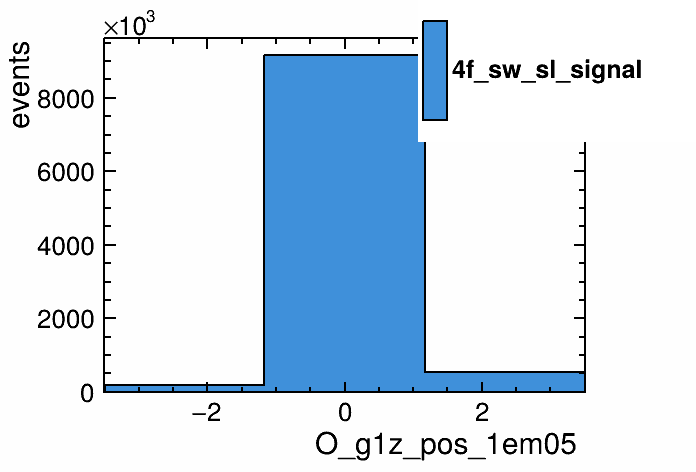

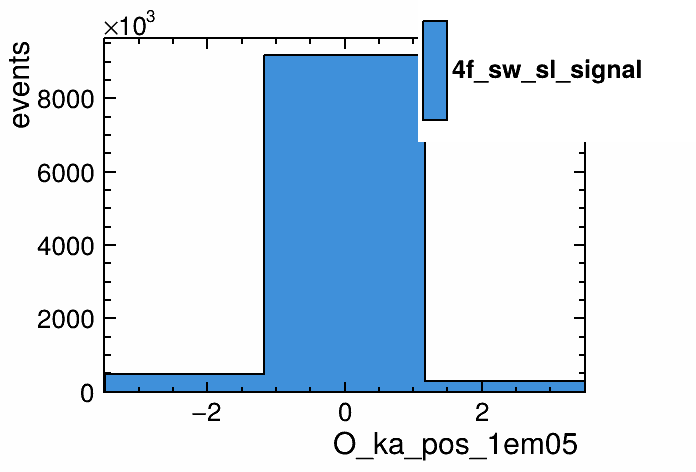

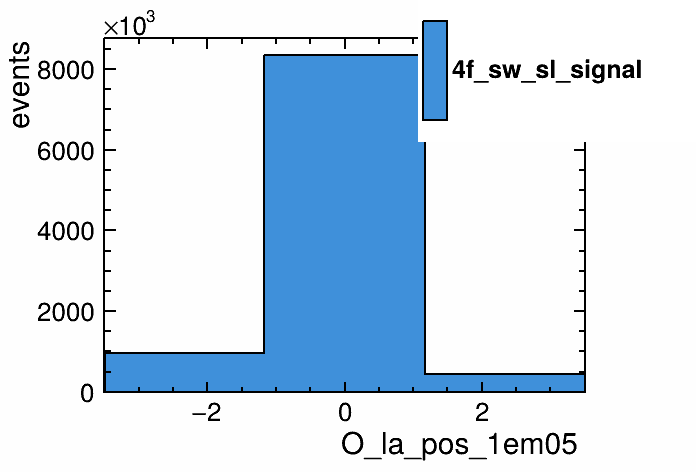

In [14]:

for name in oo_configs:
    analysis.draw_histogram(name, categories=signal_category)

****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =  2.16494e-19
NDf                       =           25
Edm                       =  2.16494e-19
NCalls                    =           22
p0                        =     0.246042   +/-   5.76448e-10 
p1                        =      5.18492   +/-   6.37859e-09 
****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =  1.06425e-21
NDf                       =           25
Edm                       =  1.06424e-21
NCalls                    =           22
p0                        =    -0.155989   +/-   4.04165e-11 
p1                        =     0.365554   +/-   4.47222e-10 
****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =  1.37093e-20
NDf                       =           25
Edm                       =  1.37093e-20
NCalls                    =           22
p0                        =     -1.18526   +/- 

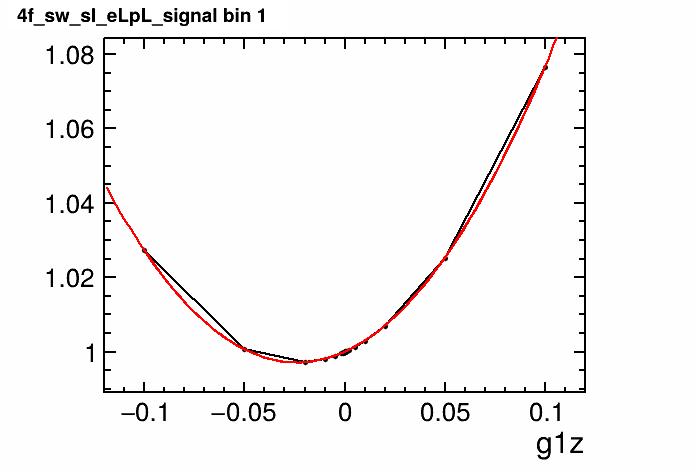

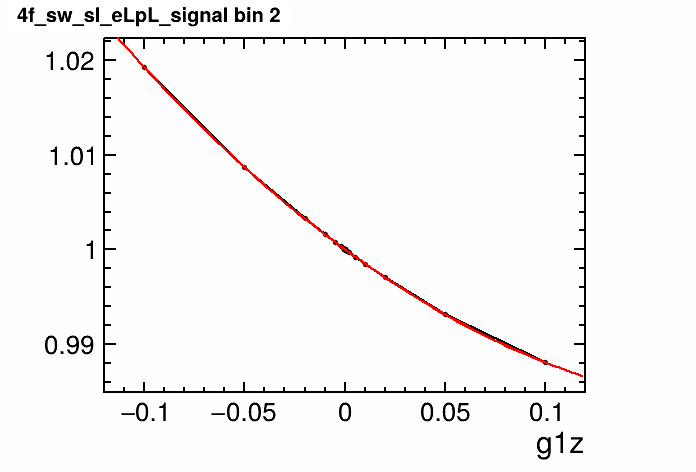

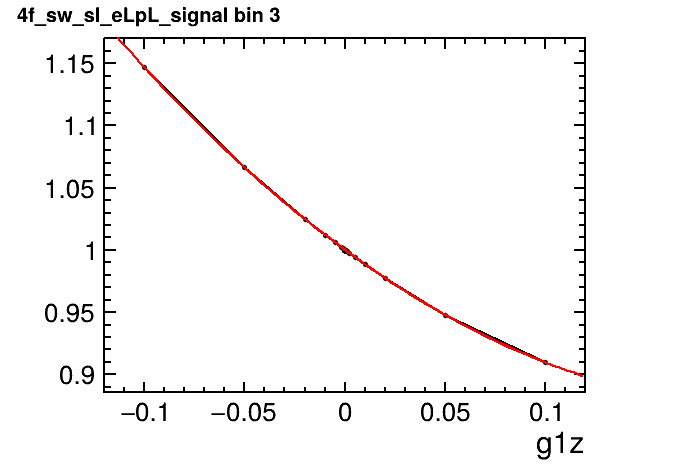

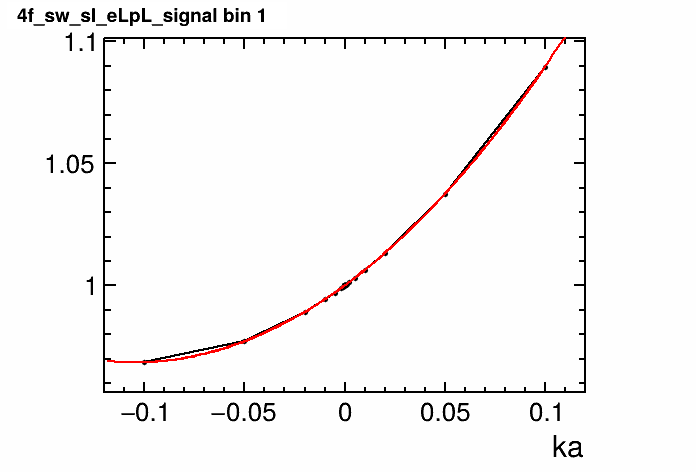

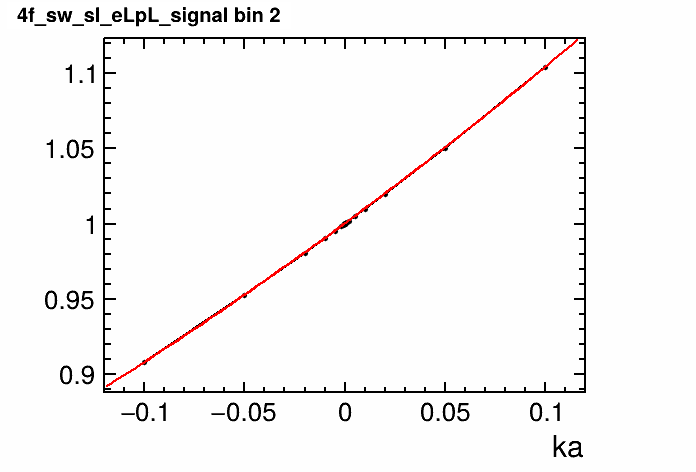

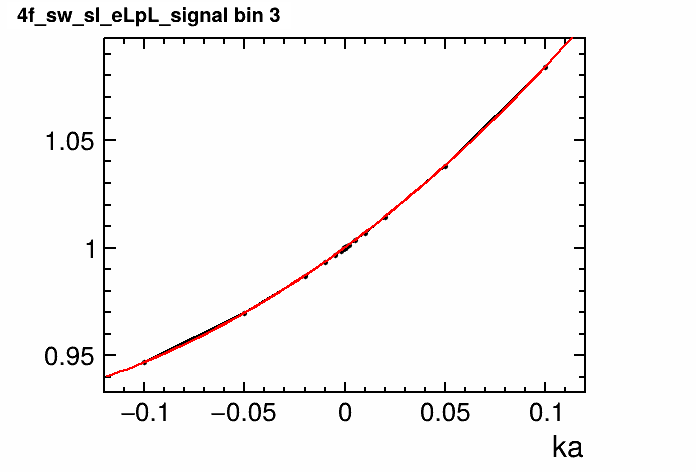

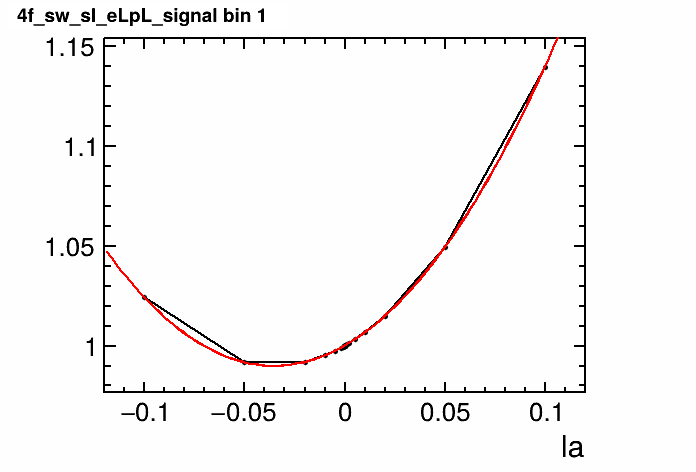

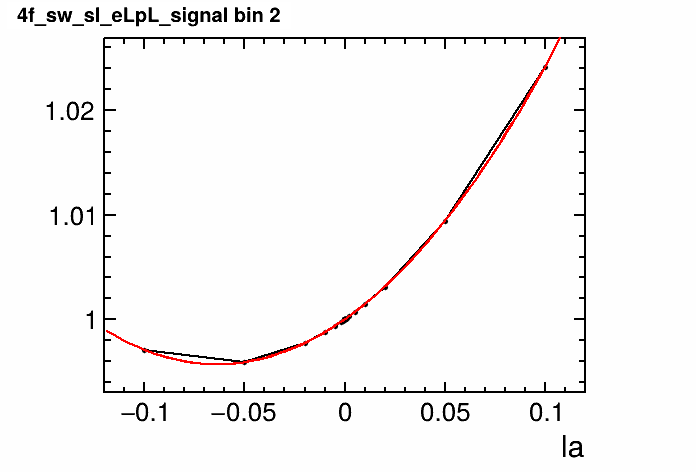

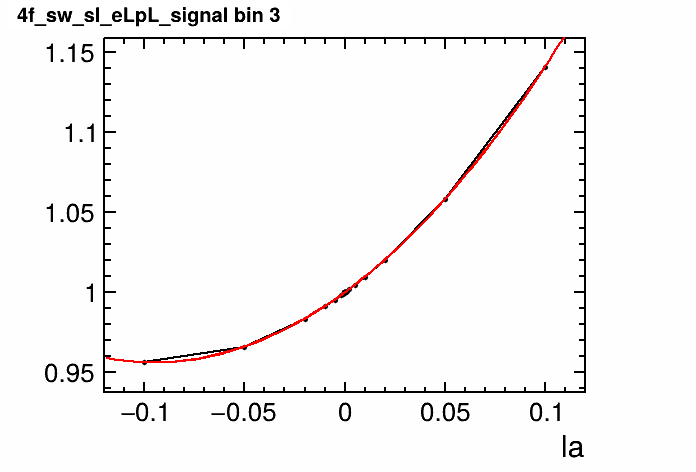

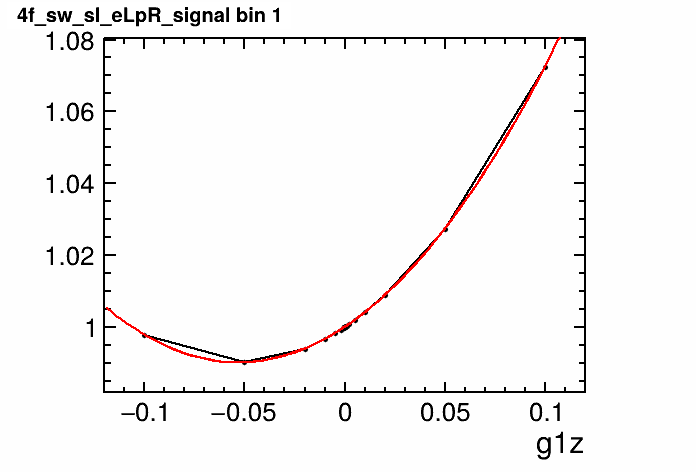

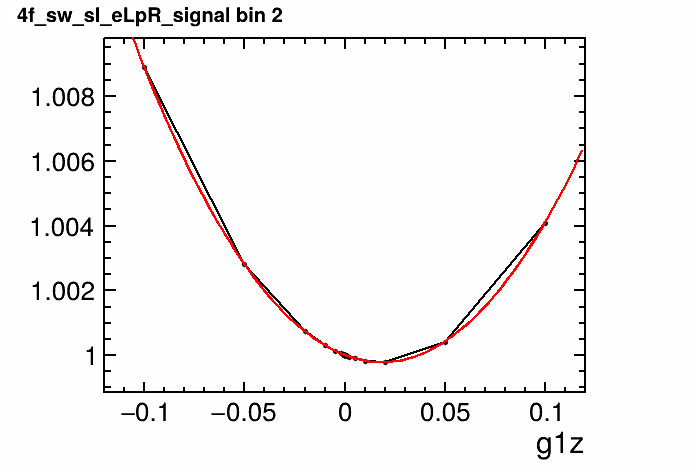

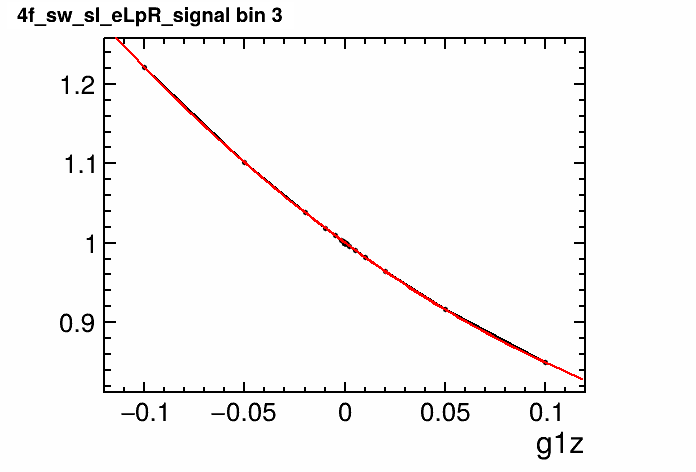

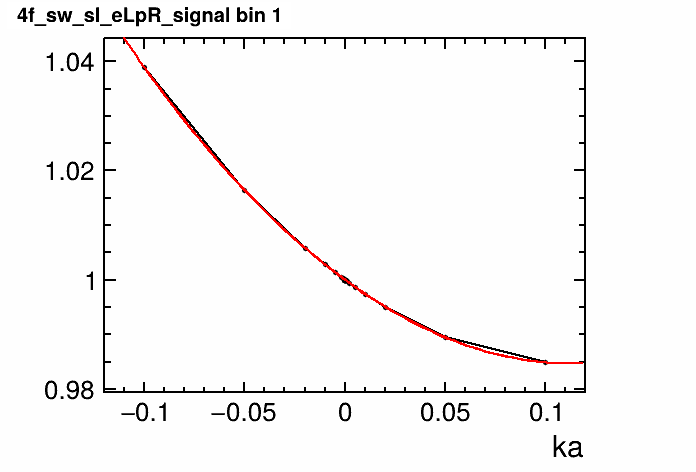

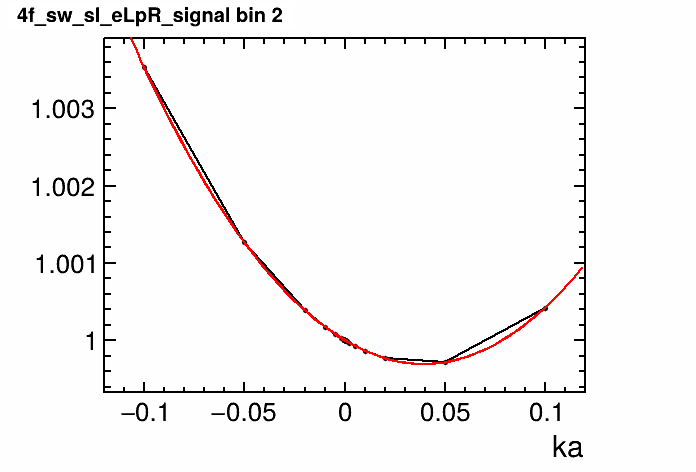

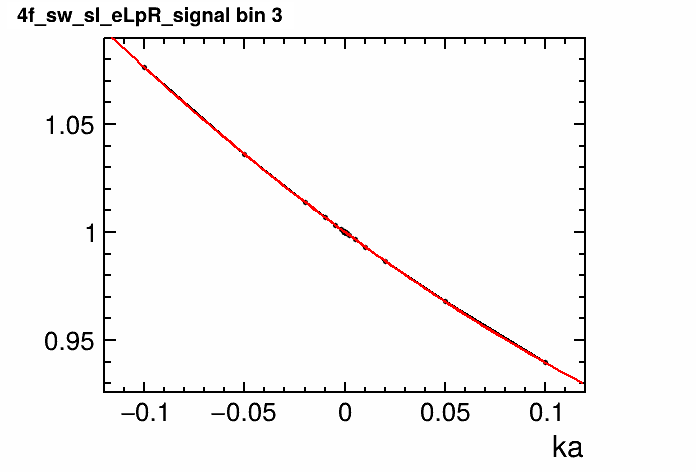

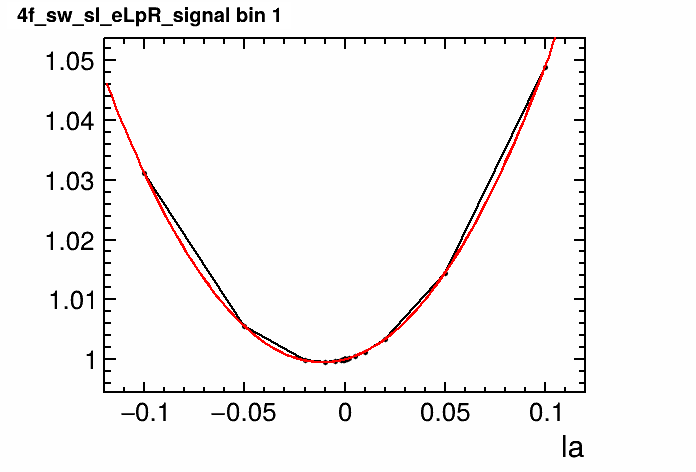

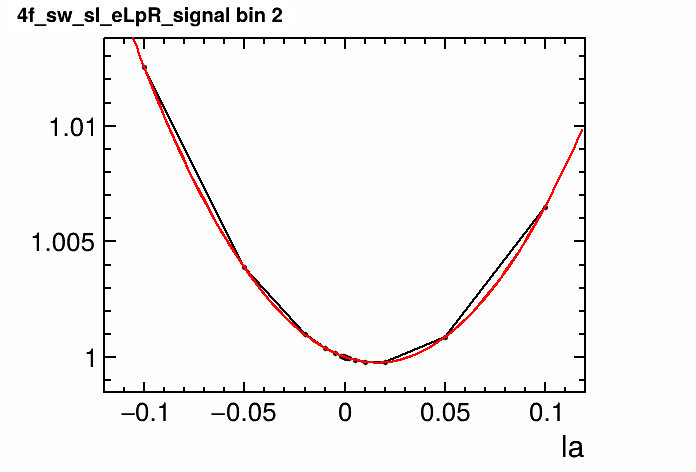

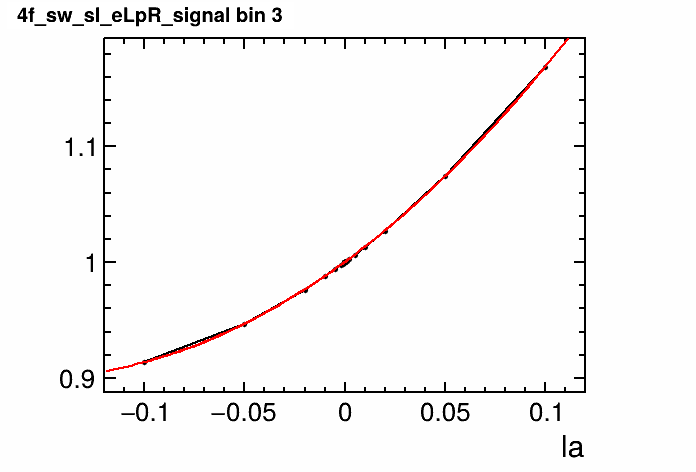

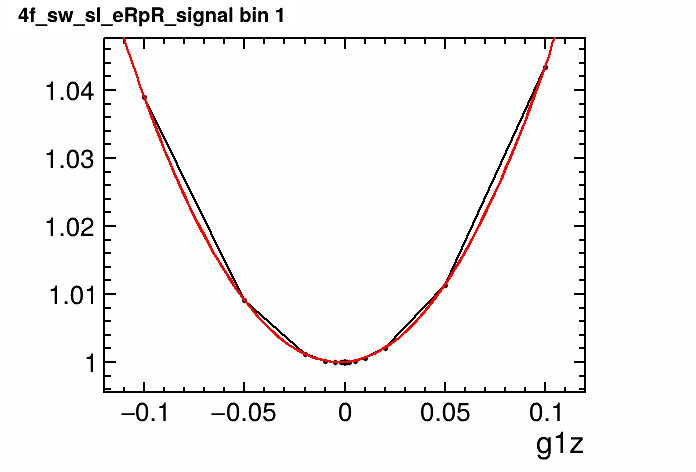

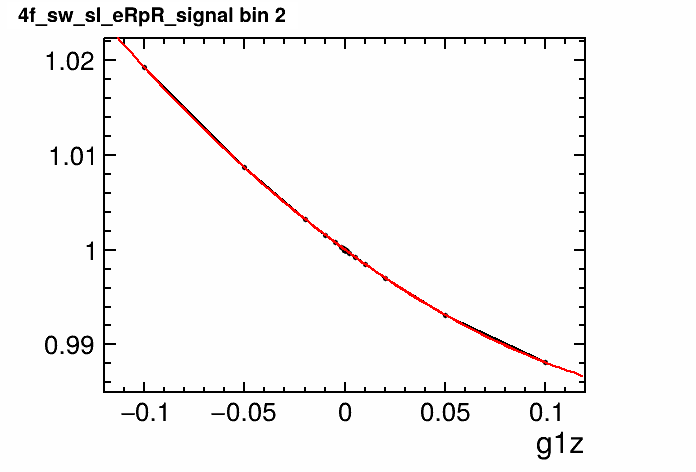

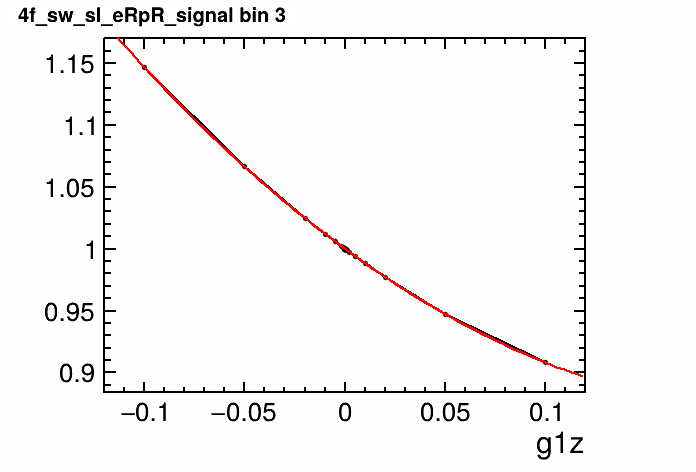

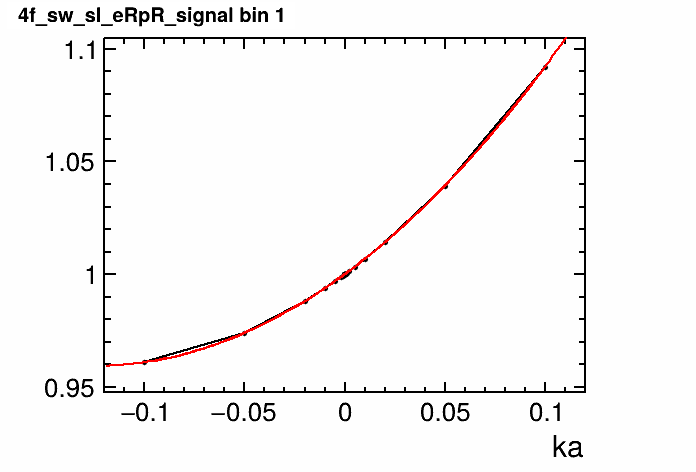

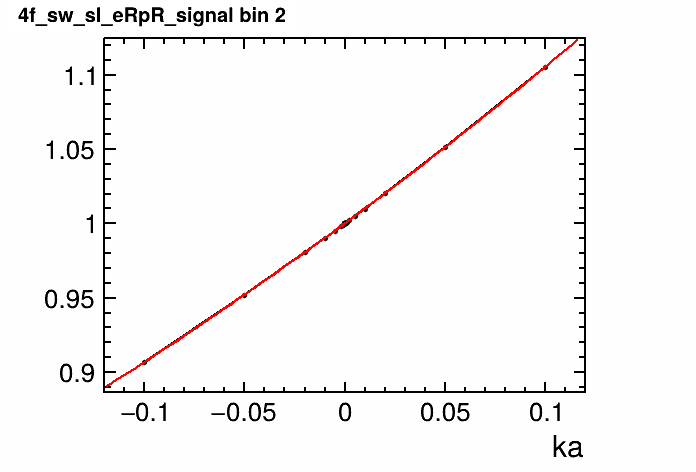

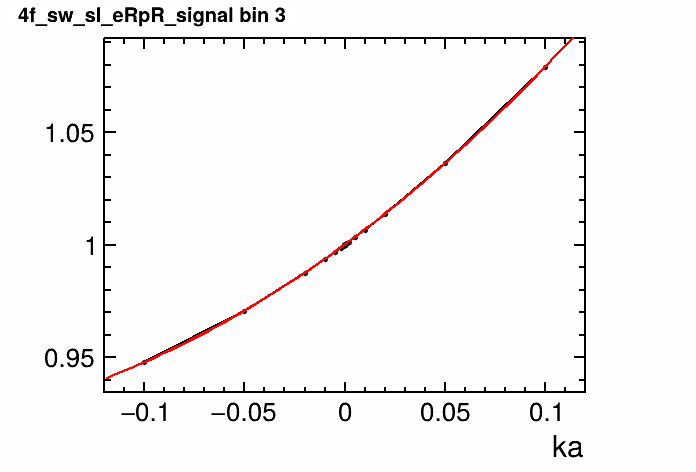

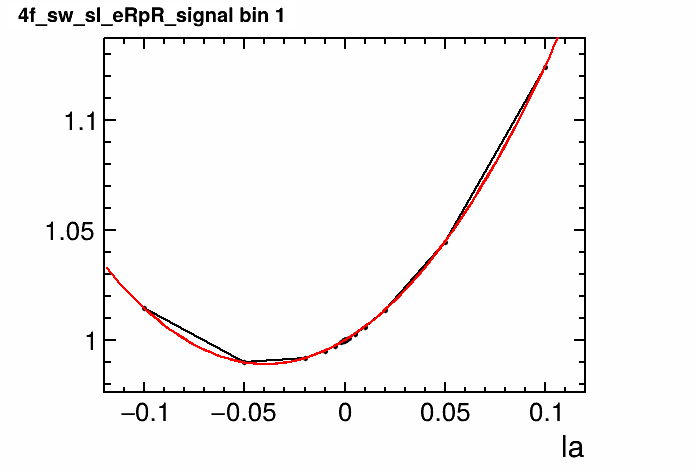

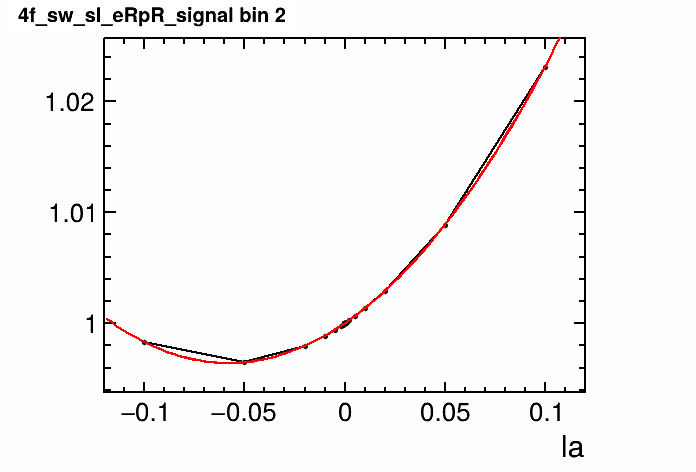

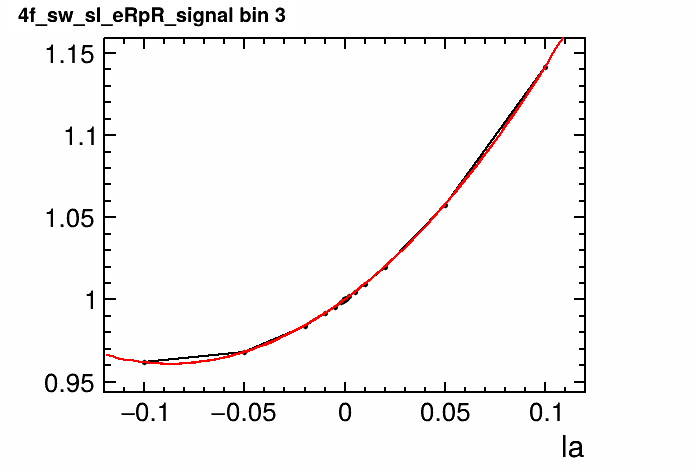

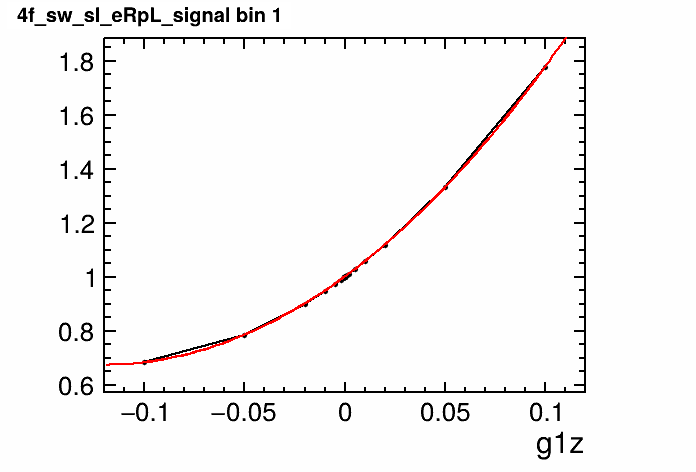

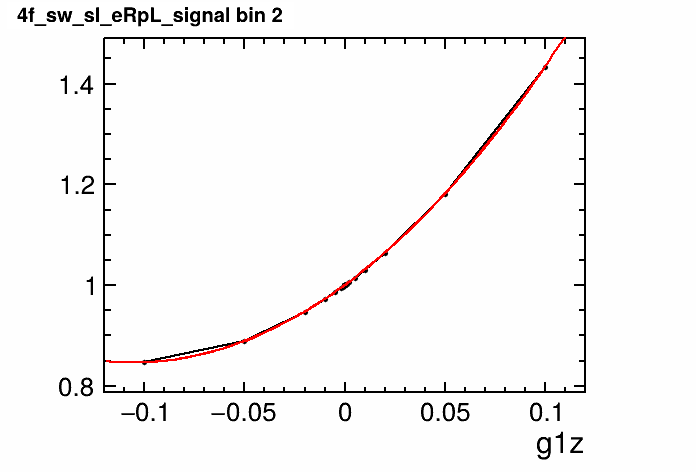

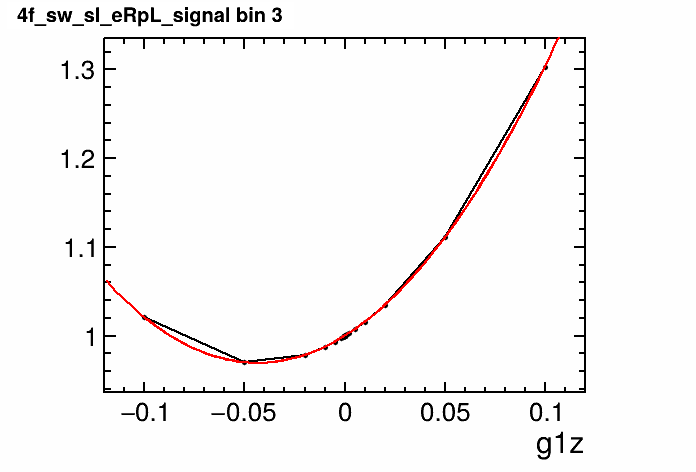

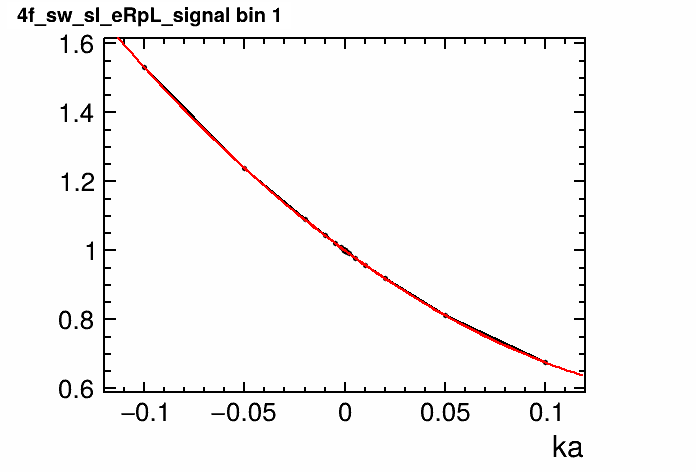

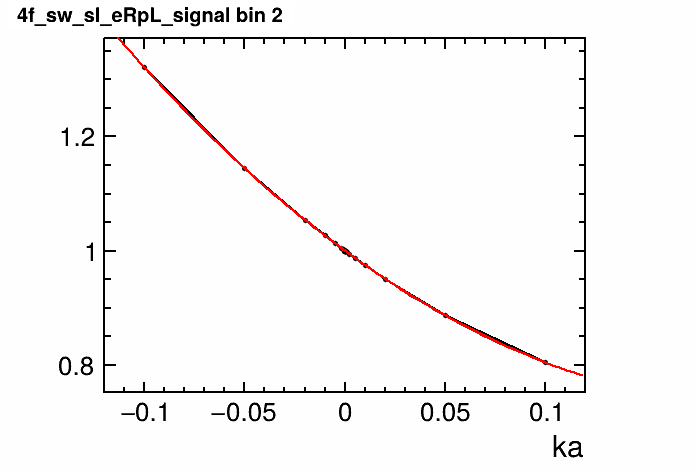

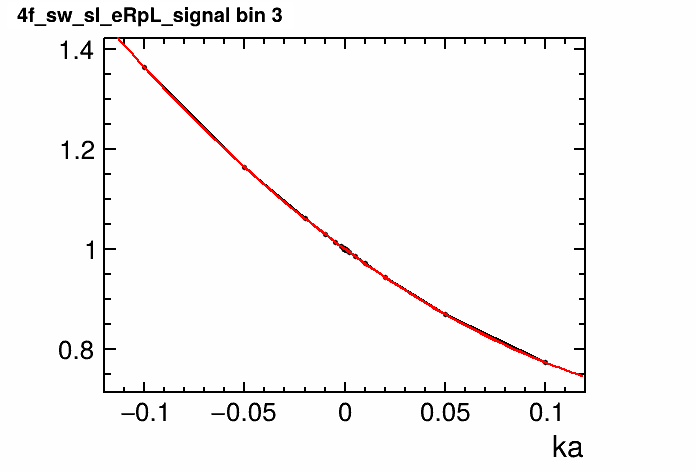

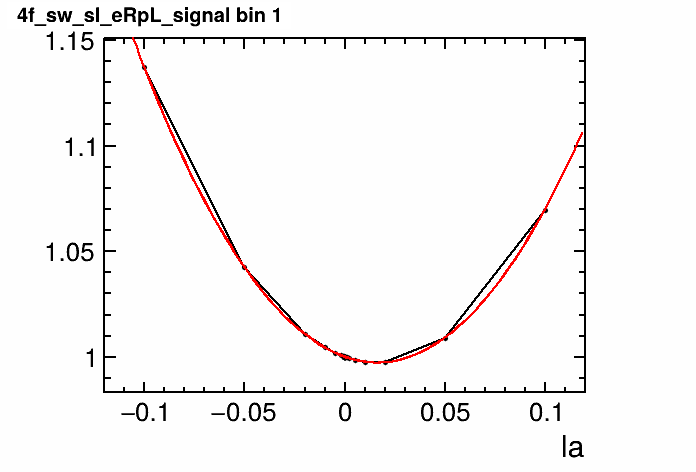

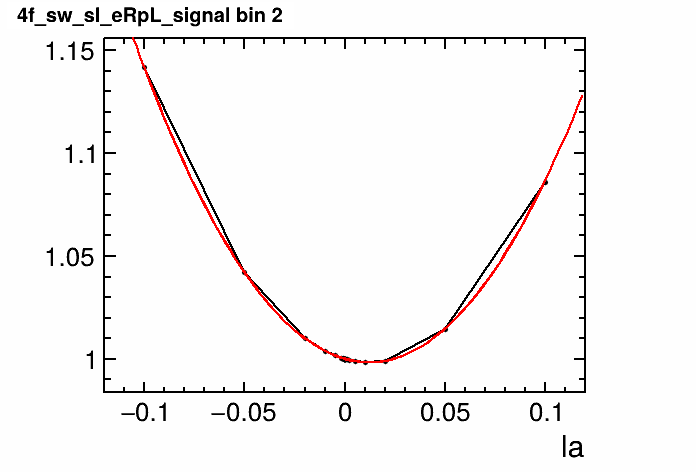

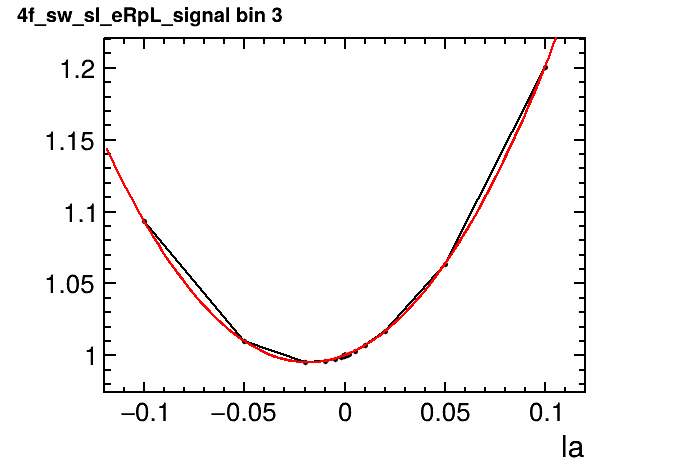

In [15]:
# analysis.plot_template_bins("O_g1z_pos_1em05", alt_setup_handler, only=oo_setups)
analysis.plot_template_bins("O_g1z_pos_1em05", alt_setup_handler)

In [16]:
canvs = analysis._canvases["template_bins"]["4f_sw_sl_eLpR_signal"]

In [17]:
print(canvs)

{'g1z': [<cppyy.gbl.TCanvas object at 0x1bfd7600>, <cppyy.gbl.TCanvas object at 0x1c0419d0>, <cppyy.gbl.TCanvas object at 0x1c3a0c40>], 'ka': [<cppyy.gbl.TCanvas object at 0x1c39bb80>, <cppyy.gbl.TCanvas object at 0x1c0dac70>, <cppyy.gbl.TCanvas object at 0x1c1f56d0>], 'la': [<cppyy.gbl.TCanvas object at 0x1c165870>, <cppyy.gbl.TCanvas object at 0x1c23a5a0>, <cppyy.gbl.TCanvas object at 0x1c237150>]}
